# Kiwi Challenge 2018

## Deep Learning

## Model 1: Build a Logistic regression model using scikit-learn

In this Notebook, all the steps are explained for a better understanding of the program, some additional code that does not appear in this Notebook, it will be found in the Python code. Details of this challengue can be found [here](https://github.com/KiwiCampusChallenge/Kiwi-Campus-Challenge/blob/master/Deep-Learning-Challenge.md), please before starting, you have to run the command **python app.py download** explained earlier in ** app.ipynb** 

## Step 0: Read training Set or test Set from directory

In [3]:
import cv2
import time,random
import os,shutil
import urllib.request
import zipfile
import click
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from PIL import Image
from tensorflow.contrib.layers import flatten
NUM_CLASSES=43

def read_train_test_from_directory(path_dir):
    print("Reading data from: ",path_dir)
    Xtrain_test=[]
    Ytrain_test=[]
    for i in range(NUM_CLASSES):
        pathfile=path_dir+str(i)+"/"
        for file in os.listdir(pathfile):
            if os.path.isfile(os.path.join(pathfile, file)):
                Xtrain_test.append(np.array(Image.open(os.path.join(pathfile, file))))
                Ytrain_test.append(i)
    return np.array(Xtrain_test),np.array(Ytrain_test)

If we want to read the training data, we will call with the following command.

In [6]:
Xtrain,Ytrain=read_train_test_from_directory("images/train/")
print("Number of images: ",Xtrain.shape[0])
print("Dimensions of any images: ",Xtrain[12].shape)
print("Label class: ",Ytrain[12])

Reading data from:  images/train/
Number of images:  976
Dimensions of any images:  (25, 25, 3)
Label class:  1


in the same way that, with testSet

In [8]:
Xtest,Ytest=read_train_test_from_directory("images/test/")
print("Number of images: ",Xtest.shape[0])
print("Dimensions of any images: ",Xtest[12].shape)
print("Label class: ",Ytest[12])

Reading data from:  images/test/
Number of images:  237
Dimensions of any images:  (53, 52, 3)
Label class:  1


# Step 1: Transform Images and normalize

## Data Augmentation
The data presented is small, so it is advisable to increase the data artificially through some transformations.
We increase four times the data.

In [13]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .10 + np.random.uniform()/3.0
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1


def transform_image(img):
    ang_range = 5
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = augment_brightness_camera_images(img)
    return img


def data_augmentation(X, Y):
    x1=[]
    y1=[]
    for i in range(X.shape[0]):
        x1.append(X[i])
        y1.append(Y[i])
        for num in range(3):
            x1.append(transform_image(X[i]))
            y1.append(Y[i])
    return np.array(x1), np.array(y1)


For example if we have this image

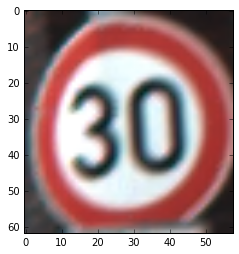

In [9]:
plt.imshow(Xtrain[21])
plt.show()

Some transformations of the previous image

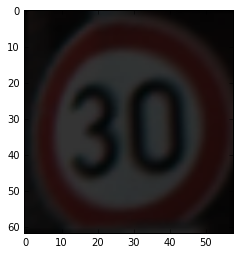

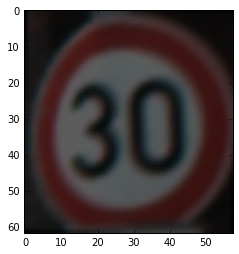

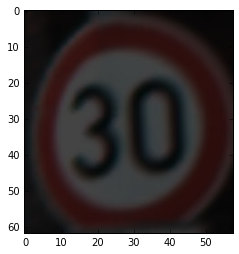

In [16]:
for i in range(3):
    plt.imshow(transform_image(Xtrain[21]))
    plt.show()

We can improve and make differents transformation,  (with this library) https://github.com/aleju/imgaug

# Feature Extraction
## Rescaling images and converts to grayscale
We resize the image to (32,32,3)
Every pixel in the image has values between [0,255], we normalize the data and transform to [-1,1]

In [17]:
def preprocess_data(X,Y):
    X_preprocess=[]
    num_of_images=X.shape[0]

    for i in range(num_of_images):
        X_preprocess.append(np.array(Image.fromarray(X[i]).resize((32, 32))))
    X_preprocess = np.array(X_preprocess)
    X_preprocess = X_preprocess.astype('float64')
    X_preprocess = (X_preprocess - 128.) / 128.

    images_gray = np.average(X_preprocess, axis=3)
    images_gray = np.expand_dims(images_gray, axis=3)
    y_onehot = np.zeros([Y.shape[0], NUM_CLASSES])

    for i in range(Y.shape[0]):
        y_onehot[i][int(Y[i])] = 1
    Y = y_onehot
    return images_gray,Y

# Step 2: Logistic Regression Model - scikit
Models will be saved in models/model1/saved/model1.sav

In [52]:
def logistic_regression_scikit(dir_train_or_test,istraining,model=-1,Xinfer=None):
    if not os.path.exists("models"):
        os.makedirs("models")
    if not os.path.exists("models/model1"):
        os.makedirs("models/model1")
    if not os.path.exists("models/model1/saved"):
        os.makedirs("models/model1/saved")

    filename = 'models/model1/saved/model1.sav'
    if istraining==True:
        Xtrain, Ytrain = read_train_test_from_directory(dir_train_or_test)
        #Xtrain, Ytrain = data_augmentation(Xtrain,Ytrain)
        Xtrain, _ = preprocess_data(Xtrain, Ytrain)
        Xtrain = Xtrain.reshape([Xtrain.shape[0], -1])
        model_logistic = LogisticRegression()
        print("Training Logistic Regression Scikit")
        model_logistic.fit(Xtrain, Ytrain)
        pickle.dump(model_logistic, open(filename, 'wb'))
        print("Saved Model")
    else:
        if model==-1:
            Xtest, Ytest = read_train_test_from_directory(dir_train_or_test)
            Xtest, _ = preprocess_data(Xtest, Ytest)
            Xtest = Xtest.reshape([Xtest.shape[0], -1])
            loaded_model = pickle.load(open(filename, 'rb'))
            result = loaded_model.score(Xtest, Ytest)
            print("score: ",result)
        else:
            loaded_model = pickle.load(open(filename, 'rb'))
            predictions = loaded_model.predict(Xinfer)
            return predictions


I have commented #Xtrain, Ytrain = data_augmentation(Xtrain,Ytrain) but you can uncommented

## Training
To train the model use this command - **python app.py train -m model1 -d images/train**

In [19]:
def train(m, d):
    print("Training Phase")
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if m=="model1":
        print("Task3: Logistic Regresion - Scikit")
        logistic_regression_scikit(d,True)

    if m=="model2":
        print("Task4: Logistic Regresion - Tensorflow")
        logistic_regression_tensorflow(d,True)

    if m=="model3":
        print("Task5: LeNet Architecture - Tensorflow")
        lenet_tensorflow(d,True)


In [22]:
train("model1","images/train")

Training Phase
Task3: Logistic Regresion - Scikit
Reading data from:  images/train/
Training Logistic Regression Scikit
Saved Model


# Testing our model
To train the model use this command - **python app.py test -m model1 -d images/test**

In [23]:
def test(m, d):
    print("Test Phase")
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if m=="model1":
        if not os.path.isfile("models/model1/saved/model1.sav"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model1 -d images/test)")
            return
        print("Task3: Logistic Regresion - Scikit")
        logistic_regression_scikit(d,False)

    if m=="model2":
        if not os.path.isfile("models/model2/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model2 -d images/test)")
            return
        print("Task4: Logistic Regresion - Tensorflow")
        logistic_regression_tensorflow(d,False)

    if m=="model3":
        if not os.path.isfile("models/model3/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model3 -d images/test)")
            return
        print("Task5: LeNet Architecture - Tensorflow")
        lenet_tensorflow(d,False)


In [24]:
test("model1","images/test")

Test Phase
Task3: Logistic Regresion - Scikit
Reading data from:  images/test/
score:  0.95358649789


In [25]:
test("model1","images/train")

Test Phase
Task3: Logistic Regresion - Scikit
Reading data from:  images/train/
score:  0.998975409836


Our model predicts with accuracy 95.3%

The descriptions of classes is obtained with the following function.

In [27]:
def get_label(pathreadme="data/FullIJCNN2013/ReadMe.txt"):
    label=[]
    startline=0
    with open(pathreadme, mode='rb') as f:
        for line in f:
            x=str(line.strip())
            strline = str(startline) + " ="
            if strline in x:
                label.append(x[6:(len(x)-1)].strip())
                startline = startline + 1
    f.close()
    return np.array(label)
label=get_label()

**Some positives predictions in our model:**

Reading data from:  images/test/


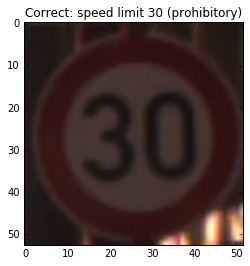

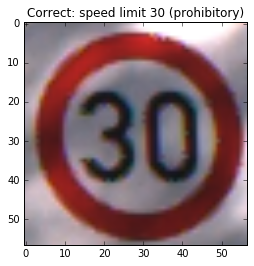

In [38]:
Xtest, Ytest = read_train_test_from_directory("images/test/")
_Xtest=Xtest
Xtest, _ = preprocess_data(Xtest, Ytest)
Xtest = Xtest.reshape([Xtest.shape[0], -1])
filename="models/model1/saved/model1.sav"
loaded_model = pickle.load(open(filename, 'rb'))
predictions = loaded_model.predict(Xtest)
cont=0
for i in range(len(predictions)):
	if Ytest[i]==predictions[i]:
		plt.imshow(_Xtest[i])
		plt.title("Correct: "+label[Ytest[i]])
		plt.show()
		cont=cont+1 
		if cont==2:
			break

**Some negatives predictions in our model:**

Reading data from:  images/test/


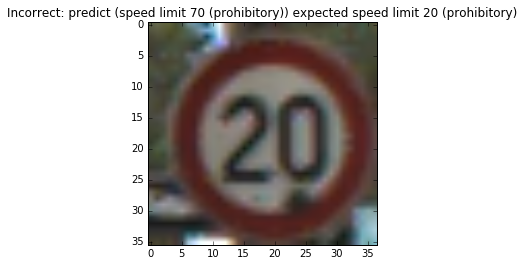

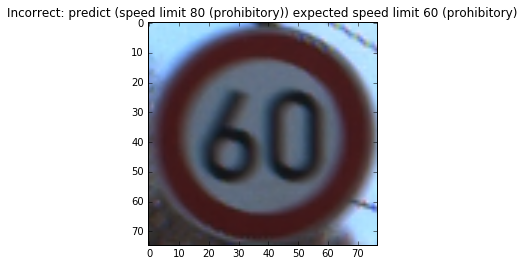

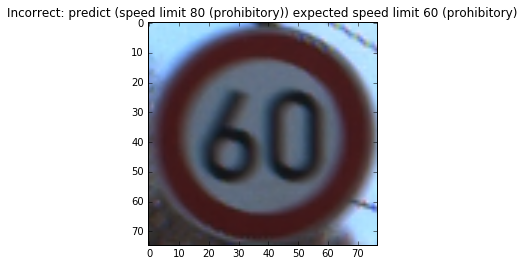

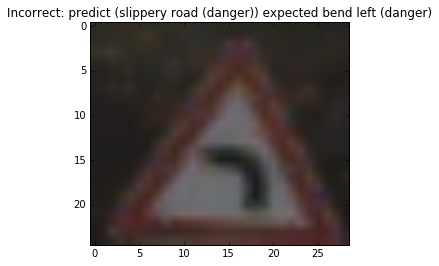

In [43]:
Xtest, Ytest = read_train_test_from_directory("images/test/")
_Xtest=Xtest
Xtest, _ = preprocess_data(Xtest, Ytest)
Xtest = Xtest.reshape([Xtest.shape[0], -1])
filename="models/model1/saved/model1.sav"
loaded_model = pickle.load(open(filename, 'rb'))
predictions = loaded_model.predict(Xtest)
cont=0
for i in range(len(predictions)):
	if Ytest[i]!=predictions[i]:
		plt.imshow(_Xtest[i])
		plt.title("Incorrect: predict ("+label[predictions[i]]+") expected "+label[Ytest[i]])
		plt.show()
		cont=cont+1
		if cont==4:
			break

# Inferences our model
To infer the model use this command - **python app.py infer -m model1 -d images/user**

In [44]:
def infer(m, d):
    print("Inference Phase - Path ",d)
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if not os.path.exists("images"):
        os.makedirs("images")
    if not os.path.exists("images/user"):
        os.makedirs("images/user")

    #get label of every class  (extracted from data/ReadMe.txt)
    label = get_label()
    label = np.array(label)
    Xinfer = []
    path_dir=d

    for file in os.listdir(path_dir):
        if os.path.isfile(os.path.join(path_dir, file)):
            if not file.endswith(".txt") and not file.endswith(".zip") \
                    and not file.endswith(".gzip") and not file.endswith(".md"):
                Xinfer.append(np.array(Image.open(os.path.join(path_dir, file))))
    Xinfer = np.array(Xinfer)
    _ = np.zeros(1)

    Xinfer, _ = preprocess_data(Xinfer, _)
    predictions = []

    if m == "model1":
        if not os.path.isfile("models/model1/saved/model1.sav"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model1 -d images/test)")
            return
        Xinfer = Xinfer.reshape([Xinfer.shape[0], -1])
        print("Task6: Inference in Logistic Regresion - Scikit")
        predictions = logistic_regression_scikit(d,False, 1, Xinfer)
        print(predictions)

    if m == "model2":
        if not os.path.isfile("models/model2/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model2 -d images/test)")
            return

        print("Task6: Inference in Logistic Regresion - Tensorflow")
        Xinfer = Xinfer.reshape([Xinfer.shape[0], -1])
        predictions = logistic_regression_tensorflow(d,False, 2, Xinfer)
        print(predictions)

    if m == "model3":
        if not os.path.isfile("models/model3/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model3 -d images/test)")
            return
        print("Task6: Inference in LeNet Architecture - Tensorflow")
        predictions = lenet_tensorflow(d,False, 3, Xinfer)
        print(predictions)

    predictions = np.array(predictions)
    cont = 0

    for file in os.listdir(path_dir):
        if os.path.isfile(os.path.join(path_dir, file)):
            if not file.endswith(".txt") and not file.endswith(".zip") \
                    and not file.endswith(".gzip") and not file.endswith(".md"):
                filepath = path_dir + file
                txt = str("Class ")
                txt = txt + str(predictions[cont])
                txt = txt + str(": ")
                txt = txt + label[predictions[cont]]
                print("label: ", txt)
                x = plt.imread(filepath)
                plt.imshow(x)
                plt.title(txt)
                plt.show()
                cont = cont + 1

You must put your images for the prediction on the path **images/user**.
We download some images on the web to infer.

Inference Phase - Path  images/user
Task6: Inference in Logistic Regresion - Scikit
[ 2 38 17 13]
label:  Class 2: speed limit 50 (prohibitory)


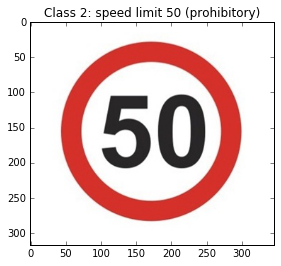

label:  Class 38: keep right (mandatory)


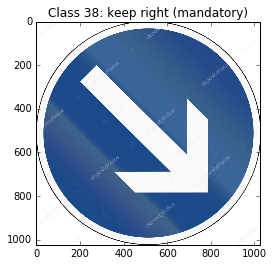

label:  Class 17: no entry (other)


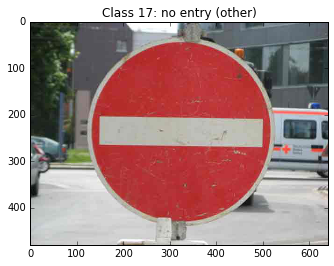

label:  Class 13: give way (other)


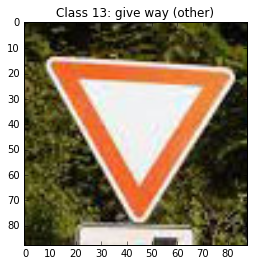

In [51]:
infer("model1","images/user")